# Spectrum Extraction and Wavelength Calibration Example

**Authors:** Hannu Parviainen </br>
**Last edited:** 2025-07-17

In [1]:
import warnings

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Polynomial1D
from astropy.nddata import CCDData, StdDevUncertainty, VarianceUncertainty
from astropy.utils.exceptions import AstropyWarning
from astropy.visualization import simple_norm
from specreduce.background import Background
from specreduce.extract import OptimalExtract, BoxcarExtract
from specreduce.tracing import FitTrace
from specreduce.wavecal1d import WavelengthCalibration1D

fheight = 2.5
fwidth = 14

plt.rcParams['figure.figsize'] = (fwidth, fheight)
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
def plot_normalized_2d_spectrum(spectrum, ax):
    ax.imshow(spectrum, norm=simple_norm(spectrum, stretch='log', min_percent=30, max_percent=99.9), origin='lower', aspect='auto')

## Read the data

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    arc = CCDData.read('data/Neon_320_20241116_194206_1sec_Bin1_-4.9C_gain0.fit', unit=u.DN)
    spectrum = CCDData.read('data/Vega_320_20241116_193604_5sec_Bin1_-5.3C_gain0.fit', unit=u.DN)
spectrum.uncertainty = VarianceUncertainty(spectrum.data)

## Take a Look at the 2D Spectra

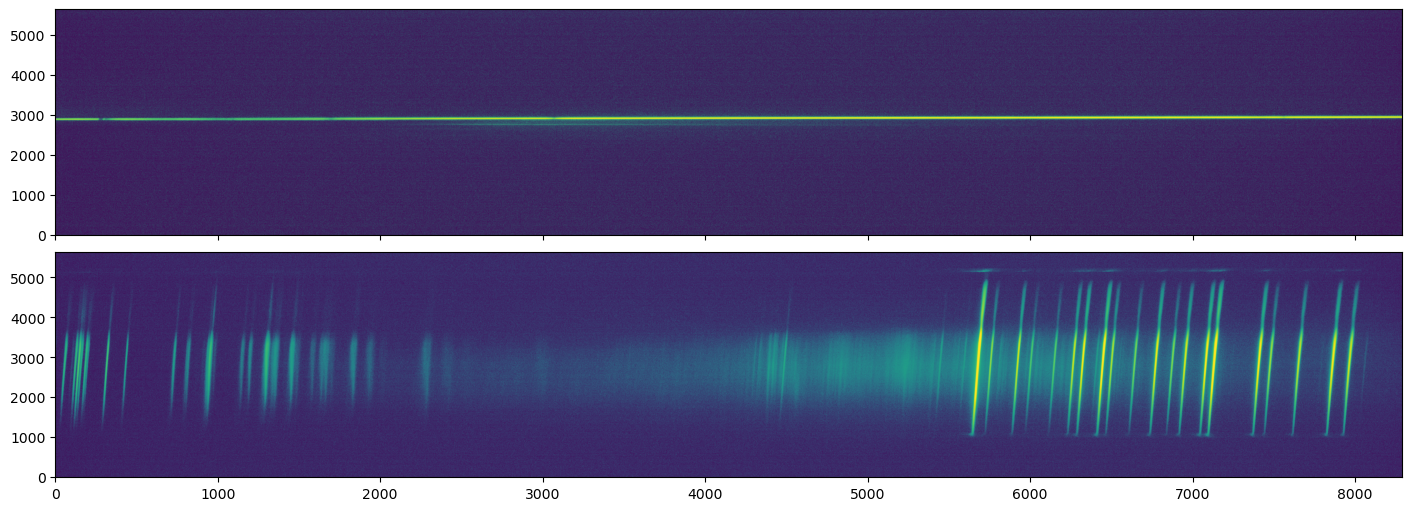

In [4]:
n = simple_norm(spectrum, stretch='log', min_percent=30, max_percent=99.9)

fig, axs = plt.subplots(2, 1, figsize=(fwidth, 2*fheight), sharex='all')
plot_normalized_2d_spectrum(spectrum, axs[0])
plot_normalized_2d_spectrum(arc, axs[1]);

## Crop the Spectrum

We can make the rest of the steps a bit faster by cropping the 2D spectra in the cross-dispersion axis.

In [5]:
spectrum = spectrum[2300:3500]
arc = arc[2300:3500]

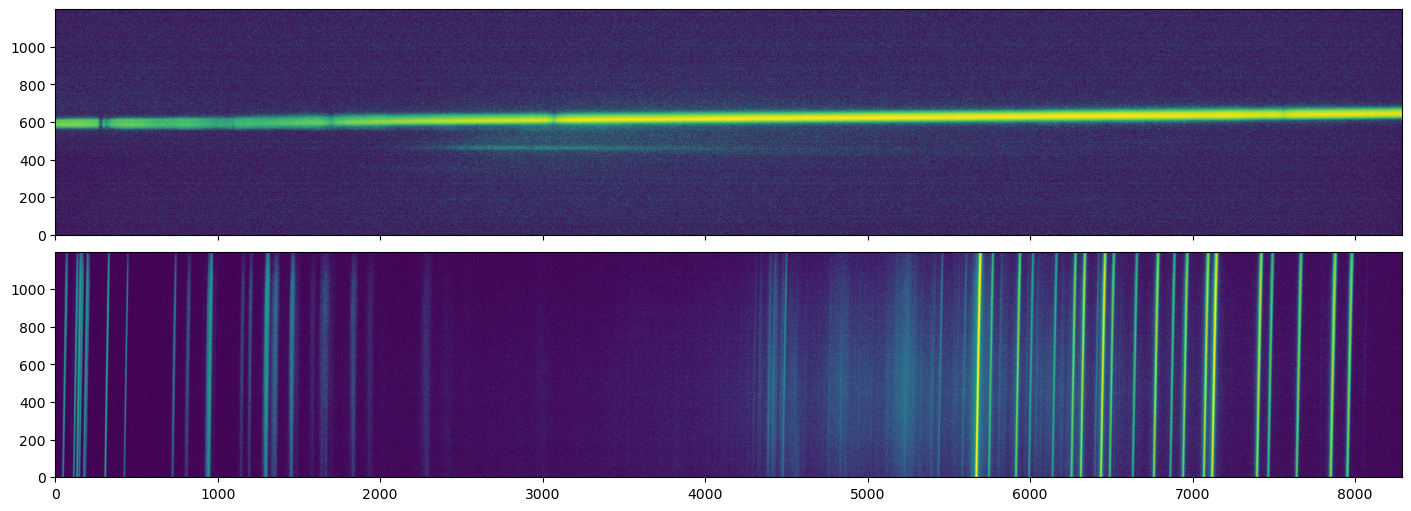

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(fwidth, 2*fheight), sharex='all')
plot_normalized_2d_spectrum(spectrum, axs[0])
plot_normalized_2d_spectrum(arc, axs[1]);

## Trace the spectrum

In [10]:
trace = FitTrace(spectrum, bins=20, guess=600, window=300, trace_model=Polynomial1D(3))

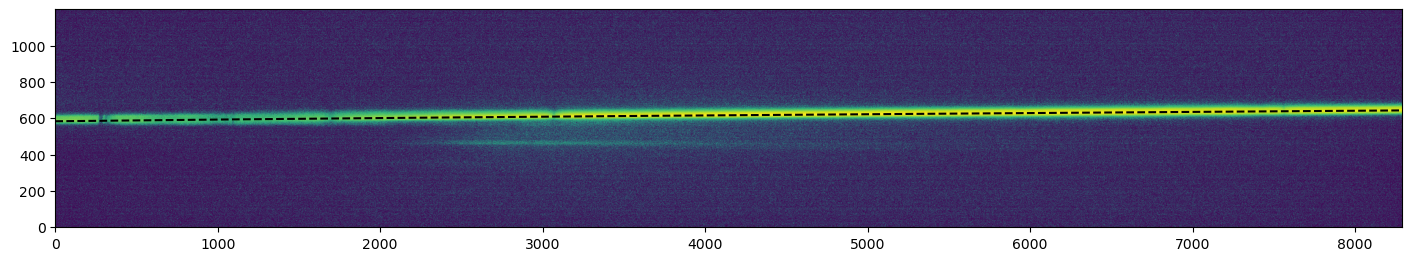

In [11]:
fig, ax = plt.subplots()
plot_normalized_2d_spectrum(spectrum, ax)
ax.plot(trace.trace, 'k--');

## Estimate and Subtract the Background

### Estimate the Background

In [12]:
background = Background.one_sided(spectrum, trace, separation=200, width=20)

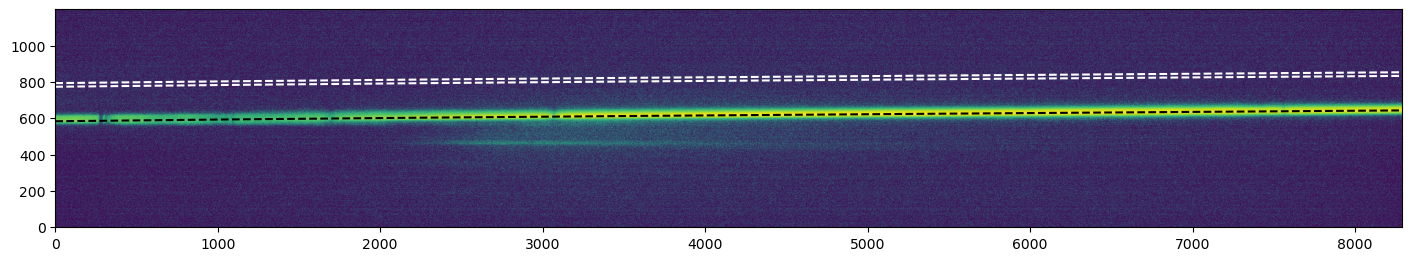

In [13]:
fig, ax = plt.subplots()
plot_normalized_2d_spectrum(spectrum, ax)
ax.plot(trace.trace, 'k--')
for bkt in background.traces:
    ax.plot(bkt.trace+background.width/2, 'w--')
    ax.plot(bkt.trace-background.width/2, 'w--')

### Subtract the Background

In [14]:
spectrum_clean = background.sub_image()

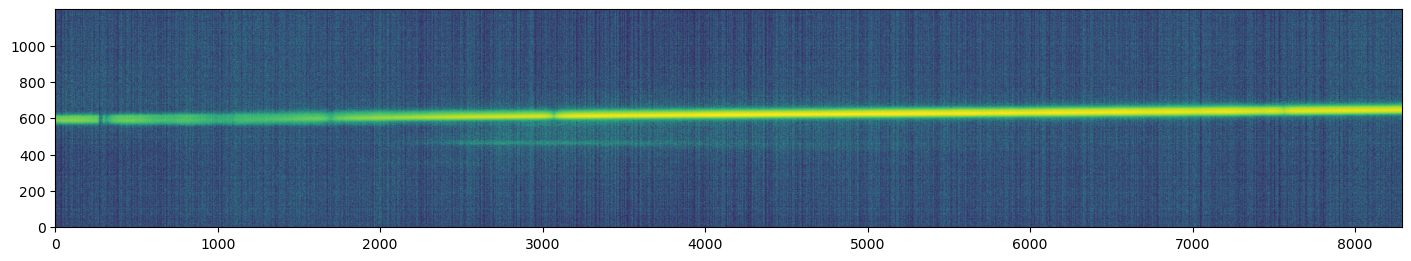

In [16]:
fig, ax = plt.subplots()
plot_normalized_2d_spectrum(spectrum_clean.flux.value, ax)

## Extract the spectrum

In [17]:
e = OptimalExtract(spectrum_clean, trace)
science_spectrum = e.spectrum

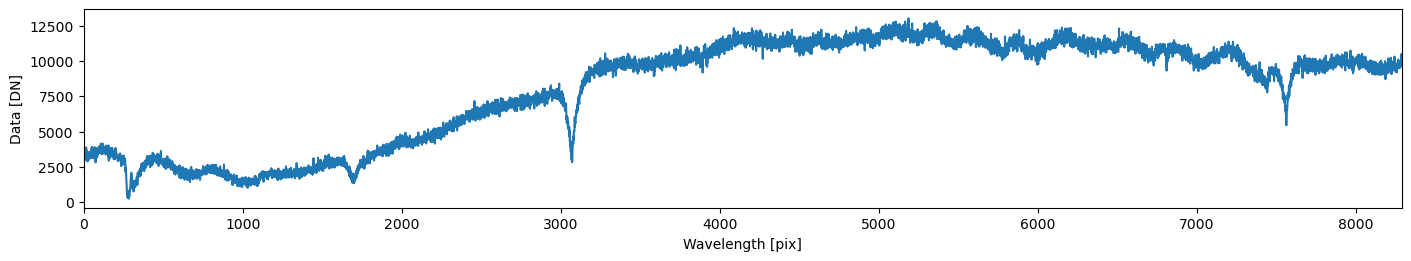

In [18]:
fig, ax = plt.subplots()
ax.plot(science_spectrum.flux)
plt.setp(ax, xlabel=f'Wavelength [{science_spectrum.spectral_axis.unit}]', ylabel=f'Data [{science_spectrum.flux.unit}]')
ax.autoscale(axis='x', tight=True)

## Calculate the 1D wavelength solution

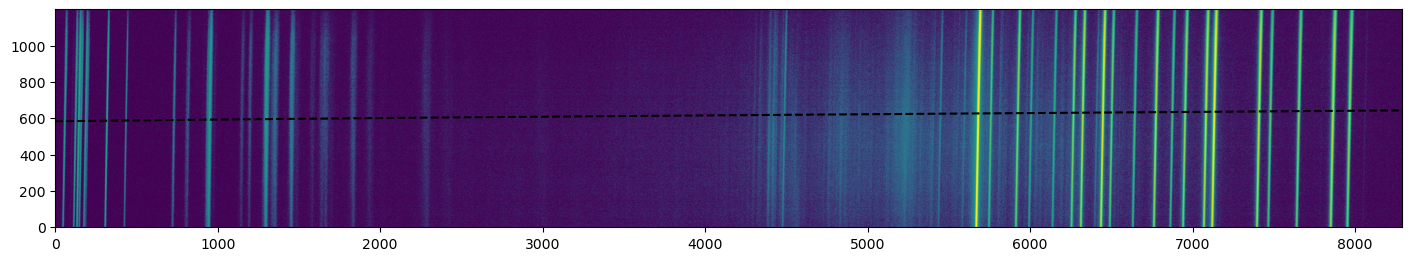

In [19]:
fig, ax = plt.subplots()
plot_normalized_2d_spectrum(arc, ax)
ax.plot(trace.trace, 'k--');

### Extract an Arc Spectrum Using the Science Spectrum Trace

In [20]:
arc_spectrum = BoxcarExtract(arc, trace, 10).spectrum
arc_spectrum.uncertainty = VarianceUncertainty(arc_spectrum.flux.value).represent_as(StdDevUncertainty)
arc_spectrum.flux[:] -= np.median(arc_spectrum.flux)

### Introduce a Custom Line List

We could use the Ne list available directly via `specreduce`, but these include much more lines than what we see in our arc frame. Let's create our own line list instead where we include the lines we can see. Let's get the Ne lines from the [ING arc maps](https://www.ing.iac.es/astronomy/instruments/af2/tn136.pdf), page 13.

In [21]:
ne_lines = np.array([5852.49, 5944.83, 6030.00, 6096.61, 6143.06, 6217.28, 6266.50, 6334.43, 6402.25, 6506.53, 6532.88, 6598.95, 6678.28, 6717.04])

### Setup 1D Wavelength Calibration

We setup the 1D wavelength calibration instance by giving it a reference pixel near the center of the spectrum, spectral-axis unit, degree of the polynomial we use to represent the pixel-to-wavelength mapping, a list of theoretical arc lines for each arc spectrum, our arc spectra (only one in this case)

In [22]:
wc = WavelengthCalibration1D(4000, u.Angstrom, degree=3, line_lists=[ne_lines], arc_spectra=[arc_spectrum], wave_air=True, line_list_bounds=(3500, 8000))

In [23]:
wc.find_lines(10, noise_factor=10)

[3500.0, 7000.0]

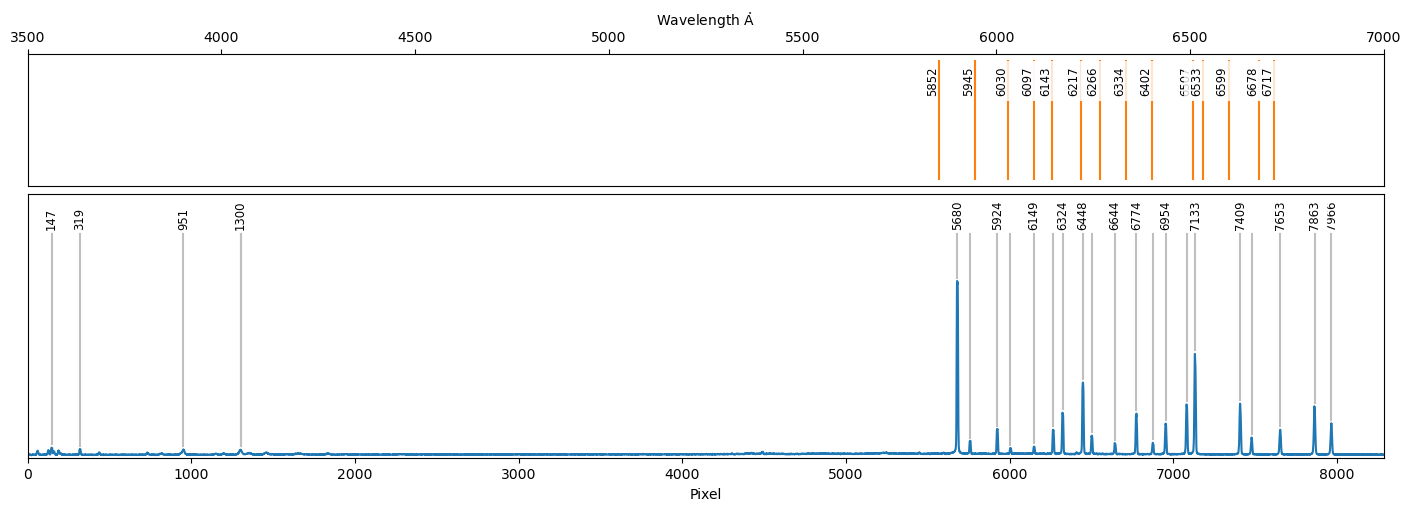

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(fwidth, 2*fheight), height_ratios=[1,2])
wc.plot_catalog_lines(axes=axs[0]);
wc.plot_observed_lines(axes=axs[1]);
plt.setp(axs[0], xlim=(3500, 7000))

### Fit lines

Here we do a manual fit to a small number of lines we've identified comparing the line list lines with the observed lines. The method calculates an initial wavelength solution based on these lines, uses this to find all the matching observed and catalog lines (with a line matching tolerance of 10 pixels), and then refines the fit using all the matched lines.

In [35]:
wc.fit_lines(pixels=[5681, 7409, 7478, 7653, 7863, 7966], wavelengths=[5852, 6507, 6533, 6599, 6678, 6717], match_obs=True, match_cat=True, refine_fit=True, refine_max_distance=10)

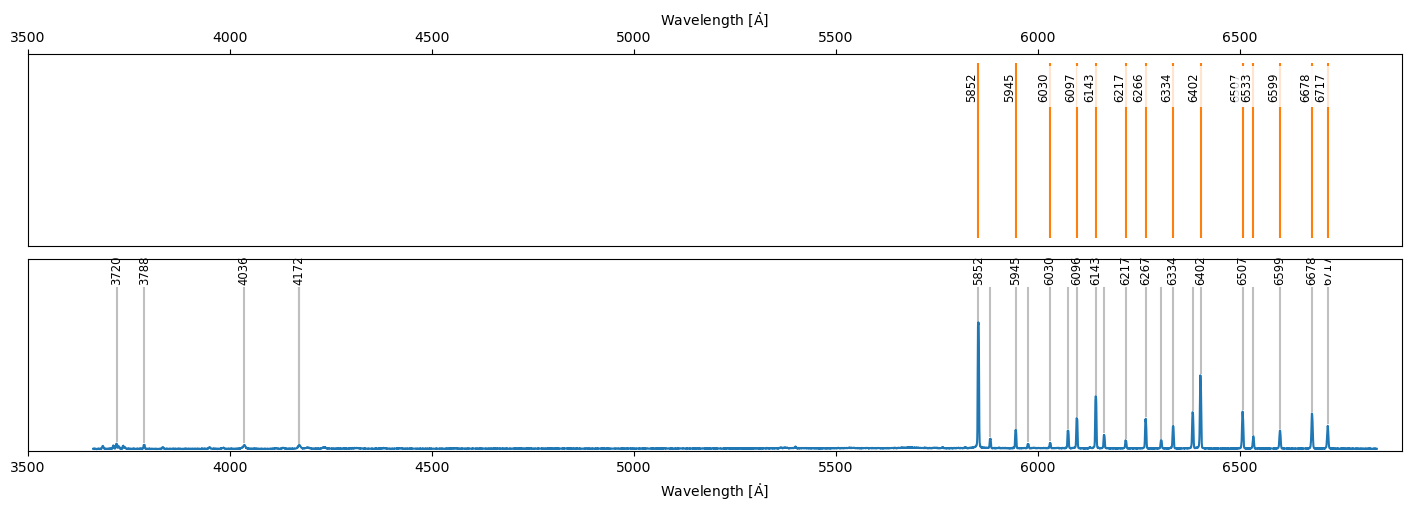

In [36]:
fig = wc.plot_fit(obs_to_wav=True, figsize=(fwidth, 2*fheight));
plt.setp(fig.axes, xlim=(3500, 6900));

The wavelength solution looks good, and all the catalog lines were matched with the observed lines. Let's still take a look at the residuals.

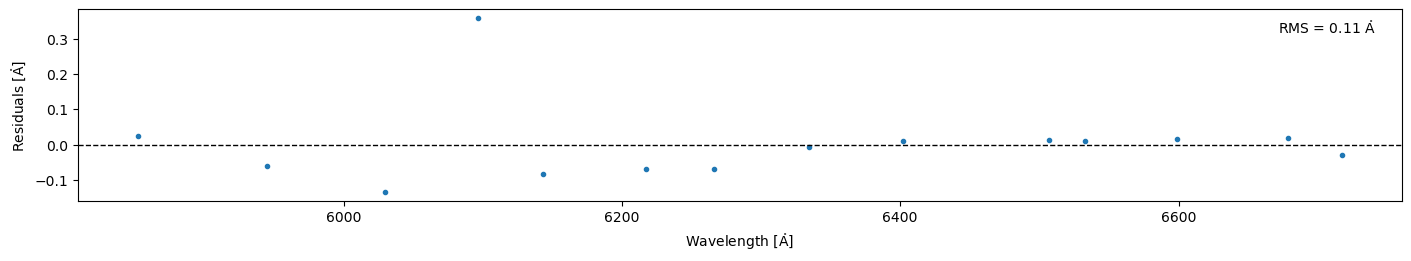

In [44]:
wc.plot_residuals();

**Note:** It is extremely likely that this wavelength solution doesn't work well at the blue end of the spectrum. The solution can be improved by adding blue Ar lines to the fit, but this is left as an exercise to the reader. 

### Resample the Science Spectrum 

The last step of our reduction is to resample the spectrum into a grid that is linear in wavelength. This can be done using the calculated wavelength solution.

In [37]:
resampled_spectrum = wc.resample(science_spectrum)

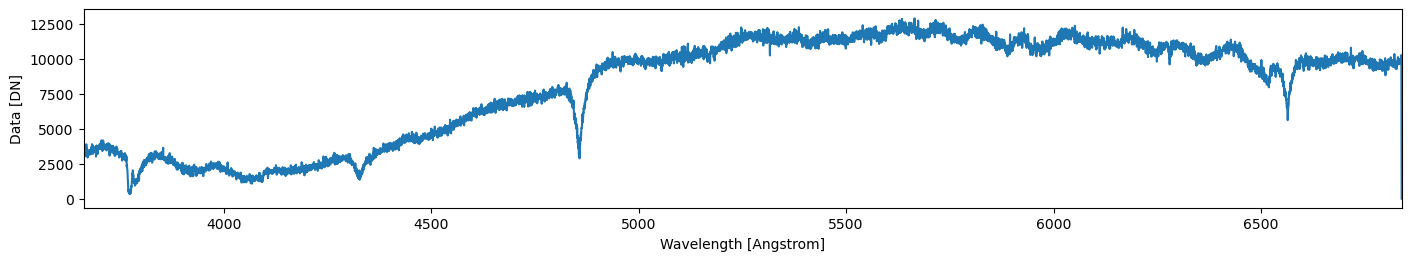

In [38]:
fig, ax = plt.subplots()
ax.plot(resampled_spectrum.spectral_axis, resampled_spectrum.flux)
plt.setp(ax, xlabel=f'Wavelength [{resampled_spectrum.spectral_axis.unit}]', ylabel=f'Data [{resampled_spectrum.flux.unit}]')
ax.autoscale(axis='x', tight=True)

In [42]:
resampled_spectrum.write('calibrated_spectrum.fits', overwrite=True)

### Sanity check: flux-preserving resampling

The resampling should preserve flux. That is, the total flux in the original 1D spectrum and the resampled spectrum should be the same. Let's check that this is the case

In [39]:
science_spectrum.flux.sum()

<Quantity 66843997.84383751 DN>

In [40]:
resampled_spectrum.flux.sum()

<Quantity 66843997.84383749 DN>